In [ ]:
!pip install vncorenlp
!pip install fastBPE
!pip install fairseq
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/ 
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

     |████████████████████████████████| 2.7MB 7.2MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-cp36-none-any.whl size=2645936 sha256=eea35cab09d659a2675b432aac0741a04a8af6e15fe8d168fa4704e4bd282766
  Stored in directory: /root/.cache/pip/wheels/09/54/8b/043667de6091d06a381d7745f44174504a9a4a56ecc9380c54
Successfully built vncorenlp
  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp36-cp36m-linux_x86_64.whl size=481515 sha256=faa5bc26808ba2c869199d21a4f6d358ab3415d39156d0f73d6c257831b9f9fa
  Stored in directory: /root/.cache/pip/wheels/f3/0c/9c/fc62058b4d473a5602bcd3d3edfece796f123875379ea82d79
Successfully built fastBPE
     |████████████████████████████████| 1.7MB 5.1MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 
     |████████████████████████████████| 133kB 27.8MB/s 
     |████████████████████████████████| 112kB 30.2MB/s 
     |████████████████████████████████| 276kB 33.0MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime

In [ ]:
!wget https://public.vinai.io/PhoBERT_base_fairseq.tar.gz
!tar -xzvf PhoBERT_base_fairseq.tar.gz
!wget https://public.vinai.io/PhoBERT_base_transformers.tar.gz
!tar -xzvf PhoBERT_base_transformers.tar.gz

--2021-01-10 16:14:18--  https://public.vinai.io/PhoBERT_base_fairseq.tar.gz
Resolving public.vinai.io (public.vinai.io)... 52.84.129.14, 52.84.129.35, 52.84.129.72, ...
Connecting to public.vinai.io (public.vinai.io)|52.84.129.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1243308020 (1.2G) [application/x-tar]
Saving to: ‘PhoBERT_base_fairseq.tar.gz’

PhoBERT_base_fairse 100%[===================>]   1.16G   117MB/s    in 10s     

2021-01-10 16:14:29 (117 MB/s) - ‘PhoBERT_base_fairseq.tar.gz’ saved [1243308020/1243308020]

PhoBERT_base_fairseq/
PhoBERT_base_fairseq/bpe.codes
PhoBERT_base_fairseq/model.pt
PhoBERT_base_fairseq/dict.txt
--2021-01-10 16:14:47--  https://public.vinai.io/PhoBERT_base_transformers.tar.gz
Resolving public.vinai.io (public.vinai.io)... 52.84.129.72, 52.84.129.35, 52.84.129.68, ...
Connecting to public.vinai.io (public.vinai.io)|52.84.129.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322405979 (307M) 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary
import argparse
import re
import csv
from vncorenlp import VnCoreNLP
import pickle 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes', 
    default="/content/PhoBERT_base_transformers/bpe.codes",
    required=False,
    type=str,
    help='path to fastBPE BPE'
)
args, unknown = parser.parse_known_args()
bpe = fastBPE(args)
bpe = fastBPE()
vocab = Dictionary()
vocab.add_from_file("/content/PhoBERT_base_transformers/dict.txt")
rdrsegmenter = VnCoreNLP("/content/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

In [ ]:
correct_mapping = {
    "ship": "vận chuyển",
    "shop": "cửa hàng",
    "m": "mình",
    "mik": "mình",
    "ko": "không",
    "k": " không ",
    "kh": "không",
    "khong": "không",
    "kg": "không",
    "khg": "không",
    "tl": "trả lời",
    "r": "rồi",
    "fb": "mạng xã hội", 
    "face": "mạng xã hội",
    "thanks": "cảm ơn",
    "thank": "cảm ơn",
    "tks": "cảm ơn",
    "tk": "cảm ơn",
    "ok": "tốt",
    "dc": "được",
    "vs": "với",
    "đt": "điện thoại",
    "thjk": "thích",
    "qá": "quá",
    "trể": "trễ",
    "bgjo": "bao giờ"
}

In [ ]:
maxlen = 125
embed_dim = 32  
num_heads = 2  
ff_dim = 32  
vocab_size=len(vocab)
epochs = 5

In [ ]:
train_path = '/content/drive/MyDrive/Comment Classification/data/train.crash'
train_csv = '/content/drive/MyDrive/Comment Classification/data/cleaned_train.csv'

In [ ]:
def load_csv_data(filepath, textcol="text_ws"):
    df = pd.read_csv(filepath)
    samples = [ str(text) for text in df[textcol] ]
    labels  = [ int(intent) for intent in df["label"]]
    return samples, labels

In [ ]:
train_data_text, train_data_label = load_csv_data(train_csv)

In [ ]:
train_sents, test_sents, train_labels, test_labels = train_test_split(train_data_text, train_data_label, test_size=0.3)

In [ ]:
len(train_sents)

11260

In [ ]:
train_ids = []
for sent in train_sents:
    subwords = '<s> ' + bpe.encode(sent) + ' </s>'
    encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
    train_ids.append(encoded_sent)

test_ids = []
for sent in test_sents:
    subwords = '<s> ' + bpe.encode(sent) + ' </s>'
    encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
    test_ids.append(encoded_sent)
    
train_ids = pad_sequences(train_ids, maxlen=maxlen, dtype="long", value=0, truncating="post", padding="post")
test_ids = pad_sequences(test_ids, maxlen=maxlen, dtype="long", value=0, truncating="post", padding="post")

In [ ]:
len(train_ids)

11260

In [ ]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'projection_dim': self.projection_dim,
            'query_dense': self.query_dense,
            'key_dense': self.key_dense,
            'value_dense': self.value_dense,
            'combine_heads': self.combine_heads
        })
        return config

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  
        key = self.key_dense(inputs)  
        value = self.value_dense(inputs)  
        query = self.separate_heads(
            query, batch_size
        )  
        key = self.separate_heads(
            key, batch_size
        )  
        value = self.separate_heads(
            value, batch_size
        )  
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  
        output = self.combine_heads(
            concat_attention
        ) 
        return output

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'att': self.att,
            'ffn': self.ffn,
            'layernorm1': self.layernorm1,
            'layernorm2': self.layernorm2,
            'dropout1': self.dropout1,
            'dropout2': self.dropout2
        
        })
        return config 

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'token_emb': self.token_emb,
            'pos_emb': self.pos_emb
            
        
        })
        return config 

In [ ]:
inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125)]             0         
_________________________________________________________________
token_and_position_embedding (None, 125, 32)           2052000   
_________________________________________________________________
transformer_block (Transform (None, 125, 32)           6464      
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                660       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0     

In [ ]:
train_labels=np.array(train_labels)
test_labels=np.array(test_labels)


In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/Comment Classification/save_model/Transformer_Encoder-Only_vietnamese_comment_classification_model'
model_checkpoint_callback = ModelCheckpoint (
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    verbose = 1,
    save_best_only=True
)

In [ ]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    train_ids, train_labels, batch_size=64, epochs=epochs, validation_split=0.3,callbacks=[model_checkpoint_callback]
)

Epoch 1/5
124/124 [==============================] - 15s 103ms/step - loss: 0.6362 - accuracy: 0.6219 - val_loss: 0.4276 - val_accuracy: 0.7772

Epoch 00001: val_accuracy improved from -inf to 0.77715, saving model to /content/drive/MyDrive/Comment Classification/save_model/Transformer_Encoder-Only_vietnamese_comment_classification_model


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Comment Classification/save_model/Transformer_Encoder-Only_vietnamese_comment_classification_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Comment Classification/save_model/Transformer_Encoder-Only_vietnamese_comment_classification_model/assets


Epoch 2/5
124/124 [==============================] - 13s 102ms/step - loss: 0.3181 - accuracy: 0.8648 - val_loss: 0.2643 - val_accuracy: 0.8964

Epoch 00002: val_accuracy improved from 0.77715 to 0.89642, saving model to /content/drive/MyDrive/Comment Classification/save_model/Transformer_Encoder-Only_vietnamese_comment_classification_model


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Comment Classification/save_model/Transformer_Encoder-Only_vietnamese_comment_classification_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Comment Classification/save_model/Transformer_Encoder-Only_vietnamese_comment_classification_model/assets


Epoch 3/5
124/124 [==============================] - 13s 102ms/step - loss: 0.2168 - accuracy: 0.9162 - val_loss: 0.4271 - val_accuracy: 0.8284

Epoch 00003: val_accuracy did not improve from 0.89642
Epoch 4/5
124/124 [==============================] - 12s 99ms/step - loss: 0.1905 - accuracy: 0.9253 - val_loss: 0.2898 - val_accuracy: 0.8855

Epoch 00004: val_accuracy did not improve from 0.89642
Epoch 5/5
124/124 [==============================] - 12s 99ms/step - loss: 0.1310 - accuracy: 0.9562 - val_loss: 0.3591 - val_accuracy: 0.8905

Epoch 00005: val_accuracy did not improve from 0.89642


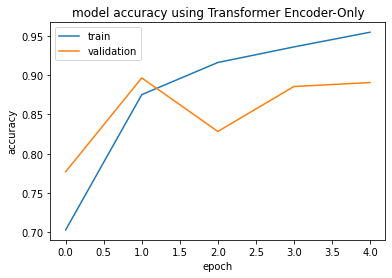

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy using Transformer Encoder-Only')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

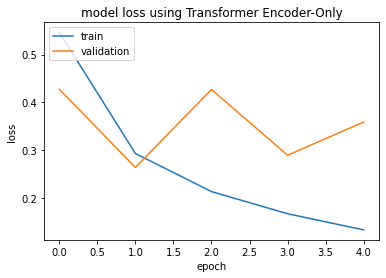

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss using Transformer Encoder-Only')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
my_model = load_model('/content/drive/MyDrive/Comment Classification/save_model/Transformer_Encoder-Only_vietnamese_comment_classification_model')

In [ ]:
score = my_model.evaluate(test_ids,test_labels)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

151/151 [==============================] - 2s 15ms/step - loss: 0.2680 - accuracy: 0.8900
Test loss:  0.2680152356624603
Test accuracy:  0.8899937868118286


In [ ]:
score = my_model.evaluate(train_ids,train_labels)
print('Train loss: ', score[0])
print('Train accuracy: ', score[1])

352/352 [==============================] - 5s 14ms/step - loss: 0.2117 - accuracy: 0.9202
Train loss:  0.2116788923740387
Train accuracy:  0.9201598763465881
